<a href="https://colab.research.google.com/github/rohitha-git/Credit-Card-Fraud-Detection/blob/main/TdocIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_path = "/content/bbc.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/bbc")

In [ ]:
!find /content/bbc -type d

/content/bbc


In [ ]:
os.listdir("/content/bbc")

['bbc-text.csv']

In [ ]:
import pandas as pd

df = pd.read_csv("/content/bbc/bbc-text.csv")
df.head()


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
df.shape

(2225, 2)

PREPROCESSING

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
stop_words = set(stopwords.words("english"))
lemm = WordNetLemmatizer()

In [ ]:
def preprocess(text):

    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # 3. Remove numbers and punctuation
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords + keep meaningful words
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]

    # 6. Lemmatize words
    tokens = [lemm.lemmatize(w) for w in tokens]

    # 7. Remove extremely short words
    tokens = [w for w in tokens if len(w) > 2]

    # 8. Reconstruct text
    return " ".join(tokens)


In [ ]:
df["clean_text"] = df["text"].apply(preprocess)
df.head()

,category,text,clean_text
0,tech,tv future in the hands of viewers with home th...,future hand viewer home theatre system plasma ...
1,business,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle cup premiership side ne...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,      # limit to top 5000 informative words
    min_df=2,               # ignore extremely rare words
    max_df=0.85,            # ignore extremely common words
    ngram_range=(1,2)       # use unigrams + bigrams
)

X_tfidf = tfidf.fit_transform(df["clean_text"])

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (2225, 5000)


KMeans Clustering (TF-IDF)

In [ ]:
from sklearn.cluster import KMeans

k = 5
kmeans_tfidf = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_tfidf = kmeans_tfidf.fit_predict(X_tfidf)

df["cluster_tfidf"] = labels_tfidf

df[["category", "cluster_tfidf"]].head()


,category,cluster_tfidf
0,tech,3
1,business,2
2,sport,4
3,sport,4
4,entertainment,0


Evaluate Clustering (Silhouette Score)

In [ ]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_tfidf, labels_tfidf)
print("Silhouette Score (TF-IDF KMeans):", sil_score)

Silhouette Score (TF-IDF KMeans): 0.017527377341133177


THE SOLUTION: Switch to Semantic Embeddings (SBERT)

In [ ]:
!pip install -q sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import torch

# Load a pretrained SBERT model (well-balanced and efficient)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare the documents from the preprocessed text
documents = df['clean_text'].tolist()

# Encode the documents
embeddings = model.encode(documents, show_progress_bar=True, convert_to_numpy=True)

print("Embedding shape:", embeddings.shape)

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Embedding shape: (2225, 384)


KMeans Clustering using SBERT Embeddings

In [ ]:
from sklearn.cluster import KMeans

k = 5
kmeans_sbert = KMeans(n_clusters=k, random_state=42)
clusters_sbert = kmeans_sbert.fit_predict(embeddings)

df['cluster_sbert'] = clusters_sbert

df[['category', 'cluster_sbert']]


,category,cluster_sbert
0,tech,3
1,business,1
2,sport,0
3,sport,0
4,entertainment,4
...,...,...
2220,business,1
2221,politics,2
2222,entertainment,4
2223,politics,2


In [ ]:
from sklearn.metrics import silhouette_score

score_sbert = silhouette_score(embeddings, clusters_sbert)
print("Silhouette Score (SBERT KMeans):", score_sbert)

Silhouette Score (SBERT KMeans): 0.07244346


Elbow Method + Silhouette for SBERT

In [ ]:


scores = {}
inertias = {}
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    inertias[k] = kmeans.inertia_
    scores[k] = silhouette_score(embeddings, labels)

print("Silhouette Scores:", scores)
print("Inertia:", inertias)


Silhouette Scores: {2: np.float32(0.054489028), 3: np.float32(0.051886223), 4: np.float32(0.060553603), 5: np.float32(0.07244346), 6: np.float32(0.06933389), 7: np.float32(0.06413226), 8: np.float32(0.07159241), 9: np.float32(0.07128128)}
Inertia: {2: 1725.9779052734375, 3: 1648.7388916015625, 4: 1592.7764892578125, 5: 1539.216796875, 6: 1517.7530517578125, 7: 1506.934814453125, 8: 1463.704833984375, 9: 1441.4742431640625}


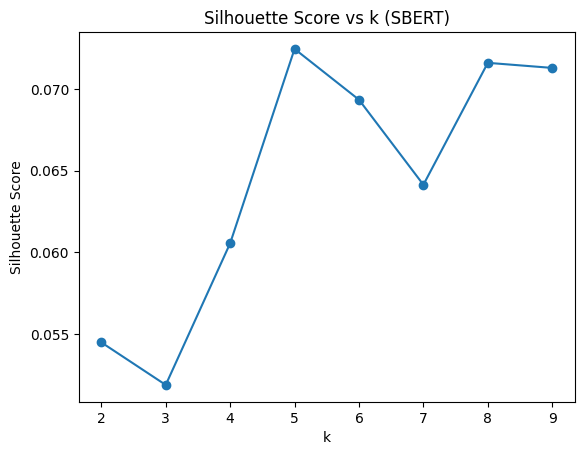

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(scores.keys()), list(scores.values()), marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k (SBERT)")
plt.show()


UMAP Visualization of SBERT Clusters

In [ ]:
!pip install umap-learn

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


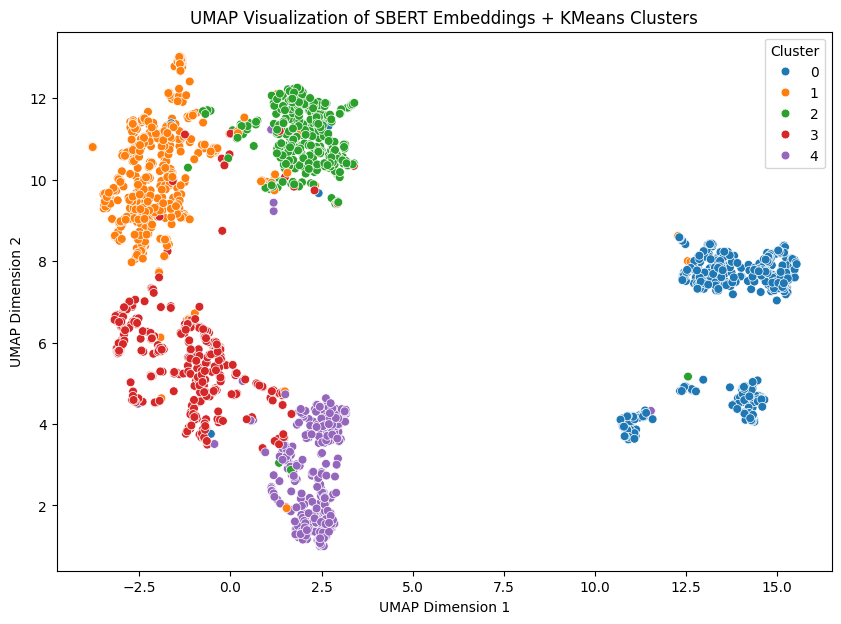

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# UMAP reduction to 2D
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

umap_2d = umap_reducer.fit_transform(embeddings)

# Fit KMeans with best k=5
kmeans_sbert = KMeans(n_clusters=5, random_state=42)
clusters_sbert = kmeans_sbert.fit_predict(embeddings)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=umap_2d[:, 0],
    y=umap_2d[:, 1],
    hue=clusters_sbert,
    palette='tab10',
    s=40
)

plt.title("UMAP Visualization of SBERT Embeddings + KMeans Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster")
plt.show()


Top Keywords for Each Cluster

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(documents)

feature_names = np.array(tfidf.get_feature_names_out())

# For each cluster → find top keywords
def get_top_keywords(cluster_id, tfidf_matrix, labels, top_n=10):
    cluster_docs = tfidf_matrix[labels == cluster_id]
    mean_tfidf = cluster_docs.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    return feature_names[top_indices]

# Print keywords for each cluster
for c in range(5):  # 5 clusters
    print(f"\nTop Keywords for Cluster {c}:")
    print(get_top_keywords(c, tfidf_matrix, clusters_sbert, top_n=12))



Top Keywords for Cluster 0:
['game' 'england' 'player' 'win' 'match' 'said' 'club' 'team' 'cup'
 'final' 'champion' 'injury']

Top Keywords for Cluster 1:
['said' 'company' 'bank' 'firm' 'year' 'growth' 'market' 'economy' 'sale'
 'price' 'share' 'rate']

Top Keywords for Cluster 2:
['said' 'labour' 'election' 'party' 'blair' 'tory' 'government' 'minister'
 'brown' 'lord' 'tax' 'howard']

Top Keywords for Cluster 3:
['mobile' 'phone' 'people' 'said' 'game' 'technology' 'user' 'service'
 'computer' 'software' 'digital' 'music']

Top Keywords for Cluster 4:
['film' 'award' 'best' 'star' 'band' 'year' 'music' 'oscar' 'said' 'actor'
 'album' 'festival']


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def semantic_search(query, top_n=5):
    # Encode query using SBERT
    query_emb = model.encode([query], convert_to_numpy=True)

    # Compute cosine similarity
    sims = cosine_similarity(query_emb, embeddings)[0]

    # Top N results
    top_idx = sims.argsort()[::-1][:top_n]

    print("\nQuery:", query)
    print("\nTop Results:\n")

    for i in top_idx:
        print(f"Score: {sims[i]:.4f}")
        print(f"Cluster: {clusters_sbert[i]}")
        print(f"Text: {documents[i][:200]}...")
        print("-" * 80)

# Test the search engine
semantic_search("latest technology updates", top_n=5)



Query: latest technology updates

Top Results:

Score: 0.4477
Cluster: 3
Text: door open biggest gadget fair thousand technology lover industry expert gathered vega annual consumer electronics show fair showcase latest technology gadget hit shop next year new product unveiled sh...
--------------------------------------------------------------------------------
Score: 0.4477
Cluster: 3
Text: door open biggest gadget fair thousand technology lover industry expert gathered vega annual consumer electronics show fair showcase latest technology gadget hit shop next year new product unveiled sh...
--------------------------------------------------------------------------------
Score: 0.4148
Cluster: 3
Text: medium gadget get moving pocket sized device let people carry around video image set big year according industry expert last year saw emergence portable medium player window based creative zen portabl...
--------------------------------------------------------------------------------
Sco

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Candidate human topic labels (BBC style)
possible_labels = [
    "sports", "business", "technology",
    "politics", "entertainment"
]

# Encode possible labels
label_embeddings = model.encode(possible_labels)

cluster_names = {}

for c in range(5):
    # get top keywords for cluster c
    keywords = get_top_keywords(c, tfidf_matrix, clusters_sbert, top_n=8)
    keyword_text = " ".join(keywords)

    # encode keywords
    keyword_embed = model.encode([keyword_text])

    # similarity with all possible topic names
    sims = cosine_similarity(keyword_embed, label_embeddings)[0]

    # pick best label
    best_label = possible_labels[np.argmax(sims)]

    cluster_names[c] = best_label

print("\nAutomatic Cluster Labels:")
for c, label in cluster_names.items():
    print(f"Cluster {c} → {label}")



Automatic Cluster Labels:
Cluster 0 → sports
Cluster 1 → business
Cluster 2 → politics
Cluster 3 → technology
Cluster 4 → entertainment


In [ ]:
!pip install gradio


In [ ]:
import gradio as gr

def search_engine(query):
    # Encode user query
    query_emb = model.encode([query], convert_to_numpy=True)

    # Compute cosine similarity
    sims = cosine_similarity(query_emb, embeddings)[0]

    # Top results
    top_idx = sims.argsort()[::-1][:5]

    results = []
    for i in top_idx:
        label = cluster_names[clusters_sbert[i]]
        text_preview = documents[i][:300].replace("\n", " ")
        score = round(float(sims[i]), 4)

        results.append(
            f"🔹 **Similarity:** {score}\n"
            f" **Cluster:** {label}\n"
            f" **Text:** {text_preview}...\n"
            "--------------------------------------"
        )

    return "\n\n".join(results)

# Build the Gradio UI
interface = gr.Interface(
    fn=search_engine,
    inputs=gr.Textbox(lines=2, placeholder="Enter your search query..."),
    outputs="markdown",
    title="BBC News Semantic Search Engine",
    description="Search the BBC dataset using SBERT + KMeans Clustering",
)

interface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5b0def442d9bddf3ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
